# Crime Data Regression Model -- Kristofer Schobert

We have taken the data from the FBI's crime data in New York State in 2013. 

https://ucr.fbi.gov/crime-in-the-u.s/2013/crime-in-the-u.s.-2013/tables/table-8/table-8-state-cuts/table_8_offenses_known_to_law_enforcement_new_york_by_city_2013.xls

The suggested regression model is the following:

$$property\_crime = \alpha + population + population^2 + murder + robbery$$


Below is the code that cleans the data and prepares it for this model.

In [115]:
%matplotlib inline
import numpy as np
import pandas as pd
import scipy
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
import math
import warnings
from IPython.display import display
from sklearn import linear_model
import statsmodels.formula.api as smf

data_path = 'Crime_2013.csv'
df = pd.read_csv(data_path, header=None)

#note to self: when cleaning data, be mindful of what you dataframe in needed in the end. 
#I spent way too much time cleaning data that I was just going to drop.

df = df.drop([0,1,2,3])
df = df.drop([4, 13], axis=1)
df.columns = df.iloc[0]
df = df.drop([4])
df = df.reset_index()
df = df.drop('index', axis=1)
df.columns.name = None
df = df.drop([348,349,350])

#df = df.rename(str.lower, axis='columns')
df = df.rename(index=str, columns={'City':'city',
                                   'Population':'population',
                                   'Violent\rcrime': "violent_crime",
                                   'Murder and\rnonnegligent\rmanslaughter' : "murder",
                   'Rape\r(legacy\rdefinition)2':'rape',
                   'Robbery':'robbery',
                   'Aggravated\rassault':'aggravated_assault',
                   'Property\rcrime':'property_crime',
                   'Burglary':'burglary',
                   'Larceny-\rtheft':'larceny',
                   'Motor\rvehicle\rtheft': 'motor_vehicle_theft',
                   'Arson3':'arson'})
df = df[['population', 'murder', 'robbery', 'property_crime']].copy()

In [116]:
for col in ['population', 'murder', 'robbery', 'property_crime']:
    df[col] = pd.to_numeric(df[col].str.replace(',',''))


In [117]:
df.murder = np.where(df.murder == 0, 0, 1)
df.robbery = np.where(df.robbery == 0, 0, 1)
#df.population_squared = df['population']**2

In [118]:
df['population_squared'] = df['population']**2
list(df.columns.values)
df = df[['property_crime', 'murder', 'robbery', 'population', 'population_squared']]

In [119]:
df.head()

,property_crime,murder,robbery,population,population_squared
0,12,0,0,1861,3463321
1,24,0,0,2577,6640929
2,16,0,0,2846,8099716
3,4090,1,1,97956,9595377936
4,223,0,1,6388,40806544


In [120]:
# Instantiate and fit our model.
regr = linear_model.LinearRegression()
Y = df['property_crime']
X = df[['population','population_squared','murder','robbery']]
regr.fit(X, Y)

# Inspect the results.
print('\nCoefficients: \n', regr.coef_)
print('\nIntercept: \n', regr.intercept_)
print('\nR-squared:')
print(regr.score(X, Y))


Coefficients: 
 [ 3.46570268e-02 -2.11108019e-09  1.51866535e+01 -9.62774363e+01]

Intercept: 
 -109.57533562257424

R-squared:
0.9961247104988709


Our r^2 value is very near 1. This means that sum of the residual sqares is near zero. This is good news but, we should be a bit concerend about overfitting.

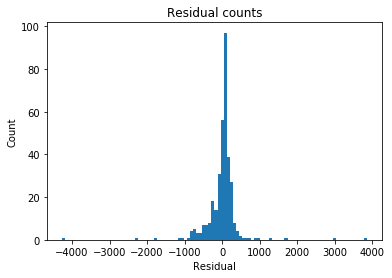

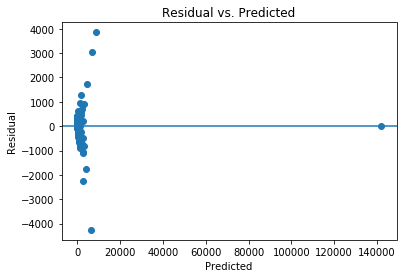

In [121]:
predicted = regr.predict(X).ravel()
actual = df['property_crime']

# Calculate the error, also called the residual.
residual = actual - predicted

# This looks a bit concerning.
plt.hist(residual, bins=100)
plt.title('Residual counts')
plt.xlabel('Residual')
plt.ylabel('Count')
plt.show()

plt.scatter(predicted, residual)
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.axhline(y=0)
plt.title('Residual vs. Predicted')
plt.show()

We see that the distrobution of residuals = (y_actual - y_predicted) is roughly normal. There is not much skew. This meets our assumption of homoscedasticity. The plot of variance in the residual vs the predicted values alerts us of an outlier. one predicted values is magnitudes larger than the rest. lets find it, remove it, and run model this again.

In [122]:
max(predicted)
for index, value in enumerate(predicted):
    if value == max(predicted):
        outlier_index = index
# df_no_outlier = df.drop([216], axis=0)
df_no_outlier = df.drop(index='216')

In [123]:
# Instantiate and fit our model.
regr = linear_model.LinearRegression()
Y = df_no_outlier['property_crime']
X = df_no_outlier[['population','population_squared','murder','robbery']]
regr.fit(X, Y)

# Inspect the results.
print('\nCoefficients: \n', regr.coef_)
print('\nIntercept: \n', regr.intercept_)
print('\nR-squared:')
print(regr.score(X, Y))


Coefficients: 
 [1.29510871e-02 1.14920528e-07 1.95038666e+02 9.28205845e+01]

Intercept: 
 -16.81586632166386

R-squared:
0.8444937611173492


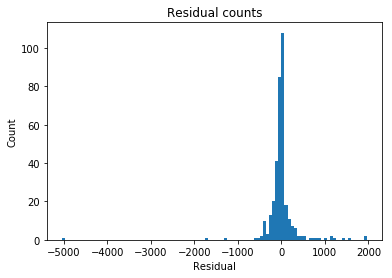

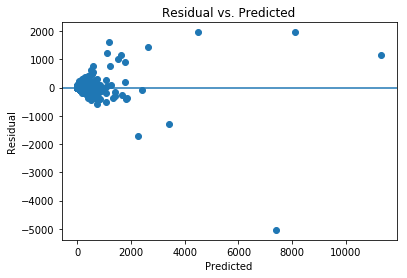

In [124]:
predicted = regr.predict(X).ravel()
actual = Y
# Calculate the error, also called the residual.
residual = actual - predicted

# This looks a bit concerning.
plt.hist(residual, bins=100)
plt.title('Residual counts')
plt.xlabel('Residual')
plt.ylabel('Count')
plt.show()

plt.scatter(predicted, residual)
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.axhline(y=0)
plt.title('Residual vs. Predicted')
plt.show()

With the outlier gone, our R-squared value is not has high, but our assumptions for our linear regression model are for the most part met. We again have a normally distributed residual, and now we can see that we more or less have homoscedasticity. Let's zoom in on the plot showing homoscedasticity.

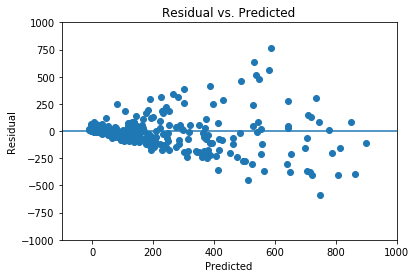

In [125]:
plt.scatter(predicted, residual)
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.xlim(-100,1000)
plt.ylim(-1000,1000)
plt.axhline(y=0)
plt.title('Residual vs. Predicted')
plt.show()

It actually seems this is not homoscedastic. The variance in the residual inceases as the predicted value increases. Let's take a look the how the variance in the residual changes with our continuous feature population.

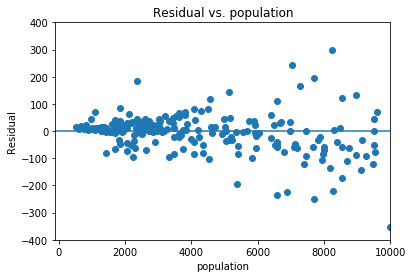

In [126]:
for col in df.columns[3:4]:
    plt.scatter(df_no_outlier[col], residual)
    plt.xlabel(col)
    plt.ylabel('Residual')
    plt.xlim(-100,10000)     
    plt.ylim(-400,400)
    plt.axhline(y=0)
    plt.title('Residual vs. ' + str(col))
    plt.show()
    

lets try taking the log of population and see what that does. 


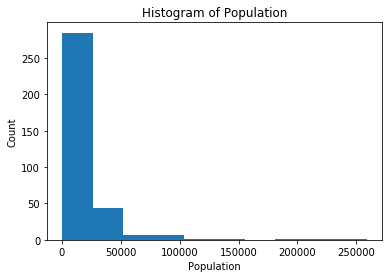

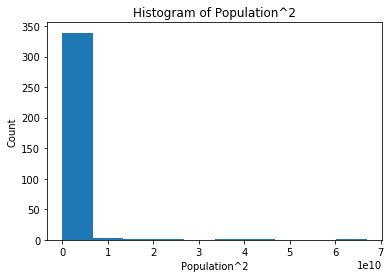

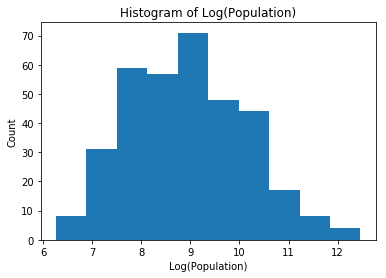

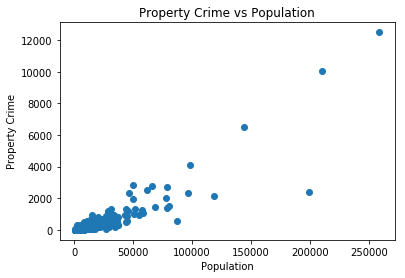

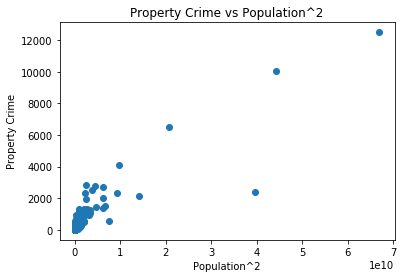

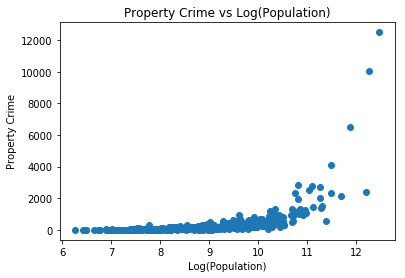

In [128]:
df_no_outlier['log_population'] = np.log(df_no_outlier.population)

plt.hist(df_no_outlier.population)
plt.ylabel("Count")
plt.xlabel('Population')
plt.title('Histogram of Population')
plt.show()
plt.hist(df_no_outlier.population_squared)
plt.ylabel("Count")
plt.xlabel('Population^2')
plt.title('Histogram of Population^2')
plt.show()
plt.hist(np.log(df_no_outlier.population))
plt.ylabel("Count")
plt.xlabel('Log(Population)')
plt.title('Histogram of Log(Population)')
plt.show()

plt.scatter(df_no_outlier.population, df_no_outlier.property_crime)
plt.ylabel('Property Crime')
plt.xlabel('Population')
plt.title('Property Crime vs Population')
plt.show()
plt.scatter(df_no_outlier.population_squared, df_no_outlier.property_crime)
plt.ylabel('Property Crime')
plt.xlabel('Population^2')
plt.title('Property Crime vs Population^2')
plt.show()
plt.scatter(df_no_outlier.log_population, df_no_outlier.property_crime)
plt.ylabel('Property Crime')
plt.xlabel('Log(Population)')
plt.title('Property Crime vs Log(Population)')
plt.show()


We see that taking the log of population has made the distibution of this feature normal, but this is not of importance. We are trying to fit a straight line to data. Of all the scatterplots, the plot of Property Crime vs. Population is most linear. The plot involving Polulation^2 is in the shape of a square root function, meaning we should be taking the square root of population^2 and using it as a feature. We are already doing that. That's population. This makes sense looking at the previous estimator for the Population^2 feature. It was of the order 10^(-7). At first, I thought this value may be small because of the large values of population. But the population values are on the order of 10^4 so this is estimator value is still roughly 0.001 times smaller. We were never including this population^2 feature much at all. Let's just try this with population only. 

In [131]:
# Instantiate and fit our model.
regr = linear_model.LinearRegression()
Y = df_no_outlier['property_crime']
X = df_no_outlier[['population','murder','robbery']]
regr.fit(X, Y)

# Inspect the results.
print('\nCoefficients: \n', regr.coef_)
print('\nIntercept: \n', regr.intercept_)
print('\nR-squared:')
print(regr.score(X, Y))


Coefficients: 
 [ 3.43860764e-02  1.43473775e+01 -9.42521334e+01]

Intercept: 
 -108.42335403478933

R-squared:
0.7889428000907828


Well this has lead to an even lower R-squared value, but at least it is not much lower. 

I am also noticing that robbery is negatively correlated with property crime. That is very counterintuitive to me. I would assume that with more robbery comes more property crime. That was the case before. We had a positive estimator for robbery. 

## Final thoughts

I believe that once we removed the outlier, model we had at the start was the best. That model being the one with the features: population, population^2, murder, robbery.  

If I were to continue investiguating to find the best model, I would try using other variables in our original dataset. I could see how burglary, larceny, motor vehical theft, and arson could all be coorelated with property crime. Though we may want to only choose a few of them, because my intuition tells me those features may be correlated with each other. 



